In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import mahotas as mh

In [3]:
import cactas as C

2023-01-29 21:08:24.447443: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [4]:
# DATAPATH = '/home/d/Dropbox/RESEARCH/CAROTID/DATA/Nathan_'
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan_Test/'
DATAPATH_PRED = '/raid/mpsych/CACTAS/DATA/Nathan_Test_Predicted2/'
TEST_DATA_IGNORE = ['41','51','61']

In [5]:
P=64

In [6]:
with open(DATAPATH+'../ESUS_stroke_side.csv', 'r') as f:
    stroke_sides = f.read().replace('ESUS ','').split('\n')

STROKE_SIDES = {}
    
for l in stroke_sides[1:]:
    l_s = l.split(',')
    
    if len(l_s) != 5:
        continue
    
    id_ = l_s[0]
    age = l_s[1]
    sex = l_s[2]
    race = l_s[3]
    side = l_s[4]
    STROKE_SIDES[id_] = side

ESUS 10
Stroke side L
Loaded /raid/mpsych/CACTAS/DATA/Nathan_Test_Predicted2/10.npy
ESUS 14
Stroke side L
Loaded /raid/mpsych/CACTAS/DATA/Nathan_Test_Predicted2/14.npy
ESUS 15
Stroke side L
Loaded /raid/mpsych/CACTAS/DATA/Nathan_Test_Predicted2/15.npy


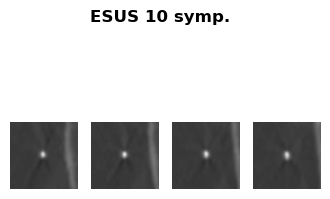

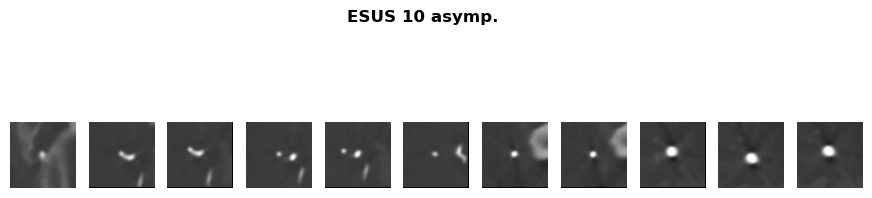

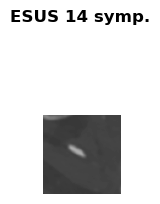

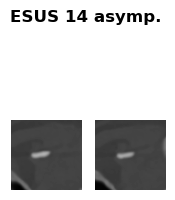

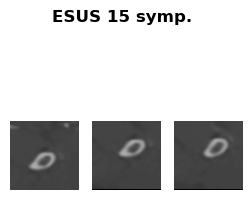

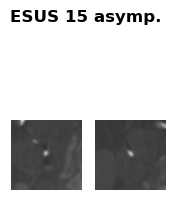

In [7]:
DATASETS = sorted([v for v in os.listdir(DATAPATH)])

images = []
labels = []

g_symp_i_patches = []
g_symp_l_patches = []
g_asymp_i_patches = []
g_asymp_l_patches = []

image_patches = []
label_patches = []

for i,d in enumerate(DATASETS[0:3]):
    

    s_stripped = d.replace('ESUS ','')
    
    if s_stripped in TEST_DATA_IGNORE:
        continue 
    
    print(d)

    image_with_header, label_with_header = C.Util.load(i, datapath=DATAPATH, with_header=True)

    spacing = [image_with_header[1]['space directions'][0,0],
               image_with_header[1]['space directions'][1,1],
               1]

    image = image_with_header[0]
    label = label_with_header[0]
    
    ### only support L P S
    if image_with_header[1]['space'] != 'left-posterior-superior':
        print('WARNING!! FATAL!!! ERROR!!! NO LPS!')
        break

    # left is Y axis from top 0 to bottom 512 (512 is full left, 0 is right)
    
    # get stroke side
    parsed_id = d.replace('ESUS ','').replace('-checked','')
    ### patient side
    stroke_side = STROKE_SIDES[parsed_id]
    print('Stroke side', stroke_side)
    
    
    #
    # LETS LOAD THE PREDICTION
    #
    label = np.load(DATAPATH_PRED+s_stripped+'.npy')
    print('Loaded', (DATAPATH_PRED+s_stripped+'.npy'))
    
    # normalize grayscale to 0..1
    image_normalized = C.Util.normalize(image)
    
    # remove empty slices
    image_filtered, label_filtered = C.Util.filter(image_normalized, label)

    # for each scan
    symp_i_patches = []
    symp_l_patches = []
    asymp_i_patches = []
    asymp_l_patches = []
    
    
    # loop thru each slice
    for z in range(image_filtered.shape[2]):

        image_slice = image_filtered[:,:,z:z+1]
        label_slice = label_filtered[:,:,z:z+1]

        # relabel the segments
        relabel, obj = mh.label(label_slice.astype(np.uint8))
        

#         print('relabeled')

        # loop thru each segment, binarize and crop
        for i in range(1, relabel.max()+1):

            single_label = np.zeros((relabel.shape), relabel.dtype)
            single_label[relabel == i] = 1

            bb = mh.bbox(single_label)

            if (bb[1]-bb[0]<=1) or (bb[3]-bb[2]<=1):
#                 print('ignoring tiny plaque',d)
                continue
            
            location = ''
            if (512-bb[0] < 256):
                location = 'L' # patient view
            else:
                location = 'R' # patient view
                
            
            
            image_cropped, single_label_cropped = C.Util.crop(image_slice, single_label, target_size=P)

#             print(location, image_cropped.shape, single_label_cropped.shape)
            
            if location == stroke_side:
                symp_i_patches.append(image_cropped)
                symp_l_patches.append(single_label_cropped)
            else:
                asymp_i_patches.append(image_cropped)
                asymp_l_patches.append(single_label_cropped)
                
            
#             image_patches.append(image_cropped)
#             label_patches.append(single_label_cropped)

#         break

    ### plot
    if len(symp_i_patches) > 0:
        symp_i_patches_a = C.Util.list_to_array(symp_i_patches)
        C.Util.view(symp_i_patches_a, symp_i_patches_a, vmin=0, vmax=1, alpha=0, title=d+' symp.' )
    else:
        print(d, 'no symp plaque')
    
    if len(asymp_i_patches) > 0:
        asymp_i_patches_a = C.Util.list_to_array(asymp_i_patches)
        C.Util.view(asymp_i_patches_a, asymp_i_patches_a, vmin=0, vmax=1, alpha=0, title=d+' asymp.' )
    else:
        print(d, 'no asymp plaque')
        
    g_symp_i_patches += symp_i_patches
    g_symp_l_patches += symp_l_patches
    g_asymp_i_patches += asymp_i_patches
    g_asymp_l_patches += asymp_l_patches
    

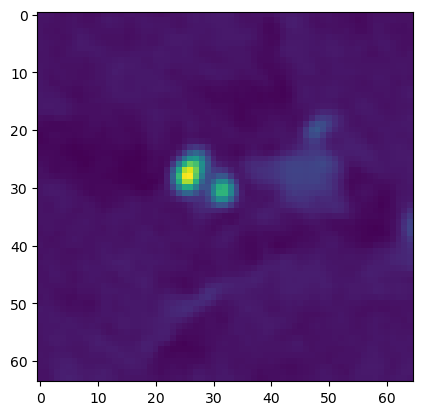

In [31]:
imshow(g_symp_i_patches[700])

(<matplotlib.image.AxesImage at 0x7f6651314e80>, 1)

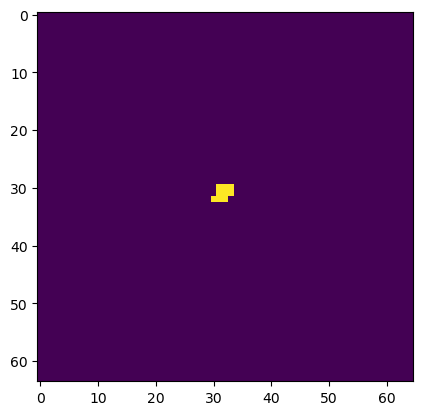

In [19]:
imshow(g_symp_l_patches[1]), g_symp_l_patches[1].max()

In [8]:
g_symp_i_patches_a = C.Util.list_to_array(g_symp_i_patches)

In [9]:
# TODO get rid of empty patches
g_asymp_i_patches_non_zero = []
for p in g_asymp_i_patches:
    if p.shape[0] == 0 or p.shape[1] == 0 or p.shape[2]==0:
        print('ignoring', p.shape)
        continue
        
    g_asymp_i_patches_non_zero.append(p)

ignoring (0, 65, 1)
ignoring (0, 65, 1)
ignoring (0, 65, 1)


In [10]:
g_asymp_i_patches_a = C.Util.list_to_array(g_asymp_i_patches_non_zero)

In [11]:
symp_images_npy = np.zeros((g_symp_i_patches_a.shape[2], P, P, 1), dtype=g_symp_i_patches_a.dtype)

for i in range(g_symp_i_patches_a.shape[2]):
    symp_images_npy[i] = g_symp_i_patches_a[0:P,0:P,i:i+1]


In [12]:
asymp_images_npy = np.zeros((g_asymp_i_patches_a.shape[2], P,P,1), dtype=g_asymp_i_patches_a.dtype)

for i in range(g_asymp_i_patches_a.shape[2]):
    asymp_images_npy[i] = g_asymp_i_patches_a[0:P,0:P,i:i+1]


In [13]:
# normalize images
# for z in range(symp_images_npy.shape[0]):
#     symp_images_npy[z] = (symp_images_npy[z] - symp_images_npy[z].min()) / (symp_images_npy[z].max() - symp_images_npy[z].min())

In [14]:
# normalize images
# for z in range(asymp_images_npy.shape[0]):
#     asymp_images_npy[z] = (asymp_images_npy[z] - asymp_images_npy[z].min()) / (asymp_images_npy[z].max() - asymp_images_npy[z].min())

In [15]:
#
# now we can store both
#
np.save(os.path.join(DATAPATH_PRED, 'asymp_cropped.npy'), asymp_images_npy)
np.save(os.path.join(DATAPATH_PRED, 'symp_cropped.npy'), symp_images_npy)